<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/image_classification/mlp_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will train an MLP to classify handwritten digits using [MNIST](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) dataset. The MNIST dataset is a set of 60,000 training images and 10,000 test images, assembled by the National Institute of Standards and Technology in the 1980s. This is considered as the "Hello World" of deep learning.

The process will be broken down into the following steps:

1. Load and visualize the dataset
2. Define a neural network
3. Define a Loss function and optimizer
4. Train the model on the training dataset
5. Evaluate the performance of the trained model on the test dataset


In [1]:
# import required libraries
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available")
else:
  print("CUDA is available")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available


### Load and visualize the dataset

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# obtain training indices for creating a validation dataset
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# choose percentage of training data for validation
valid_size = 0.2
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare train, test and validation data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# specify image classes in the dataset
classes = ['0','1','2','3','4','5', '6','7','8','9']

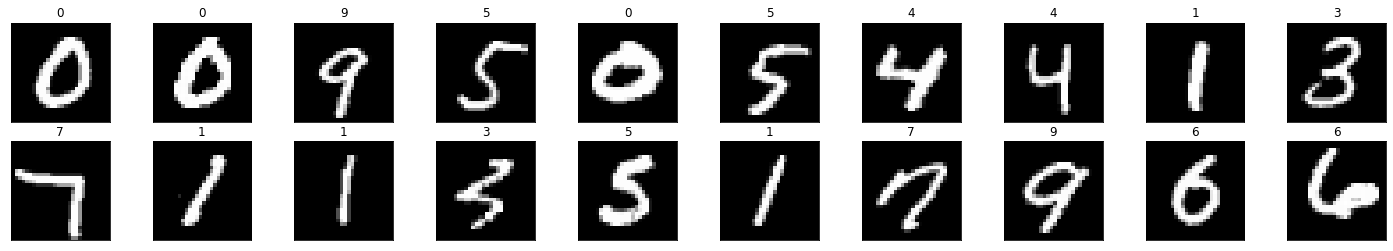

In [4]:
# visualize a batch of training data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### Define a neural network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28*28, 512) 
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 10)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x
  
model = Net()
model.to(device)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [6]:
from torchsummary import summary

# display model
summary(model, input_size=(batch_size, 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
           Dropout-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
           Dropout-4                  [-1, 512]               0
            Linear-5                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.63
----------------------------------------------------------------


### Define a Loss function and optimizer

In [40]:
import torch.optim as optim

# specify loss
criterion = nn.CrossEntropyLoss() # categorical cross-entropy loss

# specify optimizer
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005) # SGD with momentum
# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.01)

### Train the model on the training dataset

In [41]:
# number of epochs to train the model
num_epochs = 20

# track training and validation losses
train_loss, valid_loss = [], []

# initialize trackers for min validation loss
min_valid_loss = np.inf

for epoch in range(num_epochs):
  running_train_loss = 0.0
  running_valid_loss = 0.0

  #--------- train the model -----------
  # set model to training mode
  model.train()

  for batch_idx, data in enumerate(train_loader):
    # get the inputs; data is a list of [inputs, targets]
    inputs, targets = data
    # move model to the right device
    inputs, targets = inputs.to(device), targets.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # backward loss
    loss.backward()
    # update parameters
    optimizer.step()
    # update training loss
    running_train_loss += loss.item()
  # update the learning rate
  lr_scheduler.step()

  # -------- validate the model ---------
  # set model to evaluation mode
  model.eval()

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for batch_idx, data in enumerate(valid_loader):
      # get the inputs; data is a list of [inputs, targets]
      inputs, targets = data
      # move model to the right device
      inputs, targets = inputs.to(device), targets.to(device)
      # forward pass
      outputs = model(inputs)
      # calculate the batch loss
      loss = criterion(outputs, targets)
      # update validation loss
      running_valid_loss += loss.item()

  # calculate average loss over an epoch
  running_train_loss = running_train_loss / len(train_loader)
  running_valid_loss = running_valid_loss / len(valid_loader)

  train_loss.append(running_train_loss)
  valid_loss.append(running_valid_loss)

  print("Epochs: {} \tTraining loss: {:.6f} \tValidation loss: {:.6f}".format(epoch+1, running_train_loss, running_valid_loss))

  # save model if validation loss has decreased
  if running_valid_loss <= min_valid_loss:
    print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ... ".format(
        min_valid_loss, running_valid_loss
    ))

    torch.save(model.state_dict(), 'model.pt')
    min_valid_loss = running_valid_loss

print("Finished training!")

Epochs: 1 	Training loss: 0.156555 	Validation loss: 0.097787
Validation loss decreased (inf --> 0.097787). Saving model ... 
Epochs: 2 	Training loss: 0.133053 	Validation loss: 0.092871
Validation loss decreased (0.097787 --> 0.092871). Saving model ... 
Epochs: 3 	Training loss: 0.123382 	Validation loss: 0.100535
Epochs: 4 	Training loss: 0.118595 	Validation loss: 0.097859
Epochs: 5 	Training loss: 0.114483 	Validation loss: 0.089710
Validation loss decreased (0.092871 --> 0.089710). Saving model ... 
Epochs: 6 	Training loss: 0.088329 	Validation loss: 0.080160
Validation loss decreased (0.089710 --> 0.080160). Saving model ... 
Epochs: 7 	Training loss: 0.078462 	Validation loss: 0.076277
Validation loss decreased (0.080160 --> 0.076277). Saving model ... 
Epochs: 8 	Training loss: 0.074874 	Validation loss: 0.074444
Validation loss decreased (0.076277 --> 0.074444). Saving model ... 
Epochs: 9 	Training loss: 0.072974 	Validation loss: 0.073065
Validation loss decreased (0.0744

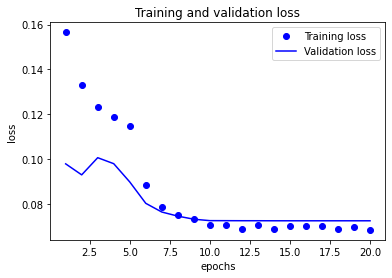

In [42]:
# plot training and validation loss for each epoch
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.show()

### Evaluate the performance of the trained model on the test dataset

In [43]:
# load model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [44]:
# track test loss and accuracy
test_loss = 0.0
class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

# set model to evaluation mode
model.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  for batch_idx, data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, targets]
    inputs, targets = data
    # get the inputs; data is a list of [inputs, targets]
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # update test loss
    test_loss += loss.item()
    # convert output probabilities to predicted class
    _, predictions = torch.max(outputs, 1)
    # compare predictions to true labels
    correct_tensor = predictions.eq(targets.data.view_as(predictions))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each class
    for i in range(batch_size):
      label = targets.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print("Test loss (overall): {:6f}\n".format(test_loss))

# print test accuracy for each classes
for i in range(len(classes)):
  if class_total[i] > 0:
    accuracy = (100 * class_correct[i]) / class_total[i]
    print(f'Test accuracy of {classes[i]:10s}: {accuracy:.1f} % ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')

# overall test accuracy
test_acc = 100 * np.sum(class_correct) / np.sum(class_total)
print("\nTest accuracy (overall): %2d%% (%2d/%2d)" % ( 
      test_acc, np.sum(class_correct), np.sum(class_total)))

Test loss (overall): 0.003430

Test accuracy of 0         : 99.1 % (971/980)
Test accuracy of 1         : 99.3 % (1127/1135)
Test accuracy of 2         : 97.7 % (1008/1032)
Test accuracy of 3         : 97.8 % (988/1010)
Test accuracy of 4         : 98.1 % (963/982)
Test accuracy of 5         : 97.0 % (865/892)
Test accuracy of 6         : 97.8 % (937/958)
Test accuracy of 7         : 98.0 % (1007/1028)
Test accuracy of 8         : 96.9 % (944/974)
Test accuracy of 9         : 96.6 % (975/1009)

Test accuracy (overall): 97% (9785/10000)


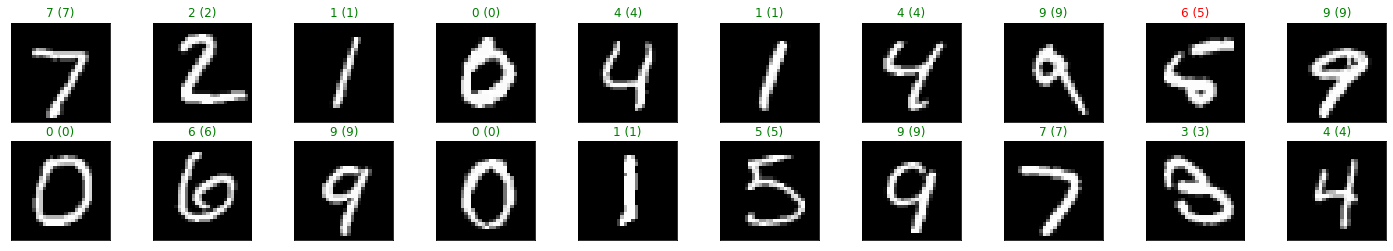

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
inputs, targets = dataiter.next()
inputs.numpy()

inputs = inputs.to(device)

# get sample outputs
outputs = model(inputs)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(outputs, 1)
predictions = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


# plot the images in the batch along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(inputs[idx]) if not train_on_gpu else np.squeeze(inputs[idx].cpu()), cmap="gray")
    ax.set_title("{} ({})".format(classes[predictions[idx]], classes[targets[idx]]),
                 color=("green" if predictions[idx]==targets[idx].item() else "red"))